In [1]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
from astropy.convolution import convolve, Gaussian2DKernel
from photutils.segmentation import detect_threshold, detect_sources
import statmorph

#statmorph script that I've modified:
from statmorph.utils.image_diagnostics_leo import make_figure as make_figure_leo
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
time_ini = datetime.now()

In [3]:
#images directory with photometric catalogues mosaics of all filters:
main_dir=f'observations/'

#imported data directories:
data_dir=f'results/morphology/'
cuts_dir_F200W=f'results/make_postage_stamps/F200W/'
seg_dir_F200W=f'results/make_postage_stamps_seg/F200W/'

#directoy to store results from this notebook:
res_dir=f'results/isophotal_analysis_statmorph/'

Firstly, we read the table with the data from the 7 candidate barred galaxies selected from visual classification.

In [4]:
table=data_dir+f'gal_visual_class_list_vsb.ecsv'
data_sample = ascii.read(table)

#list of galaxies ID:
gal_list=data_sample['ID']
gal_z=data_sample['z']

# 1. Segmentation maps:

We need to create segmentation maps so we can run statmorph to fit the ellipses and create a Sèrsic model. JADES provides segmentation maps for each source (https://archive.stsci.edu/hlsps/jades/hlsp_jades_jwst_nircam_goods-s-deep_segmentation_v2.0_drz.fits), so the first step will be to compare these maps to the maps I create using photutils package.

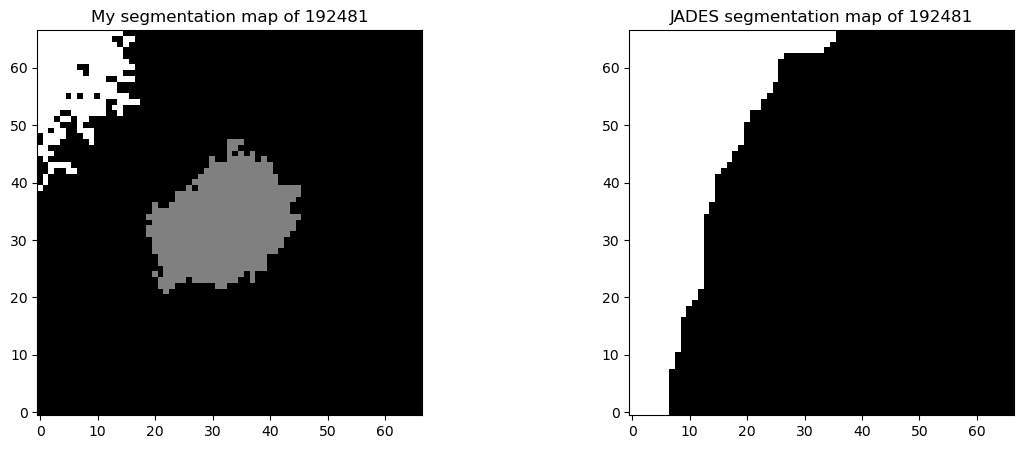

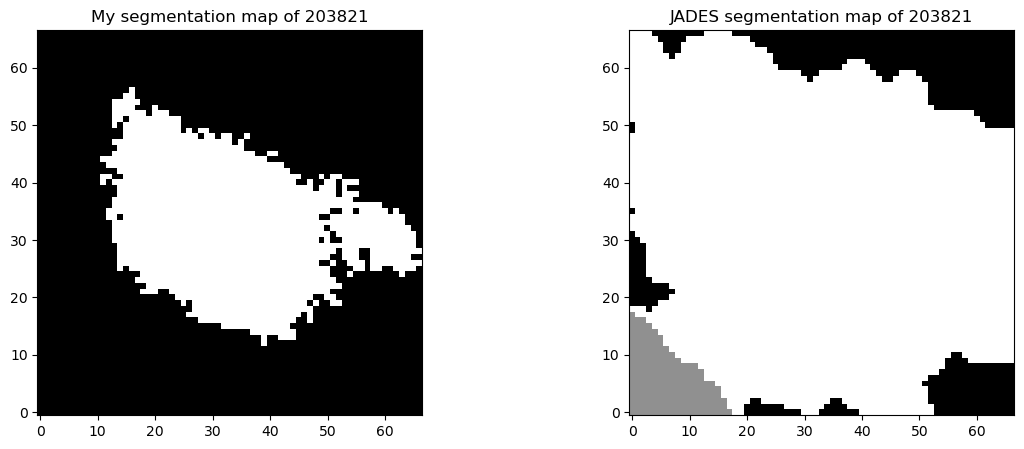

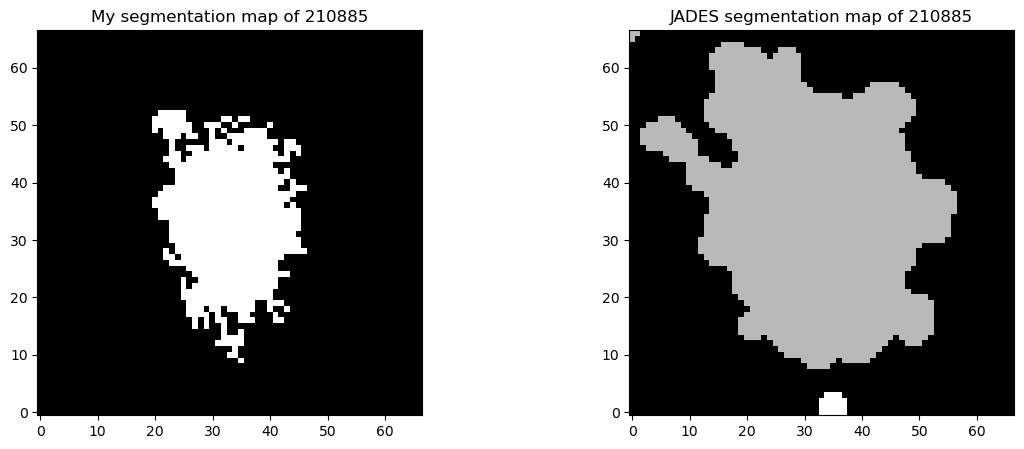

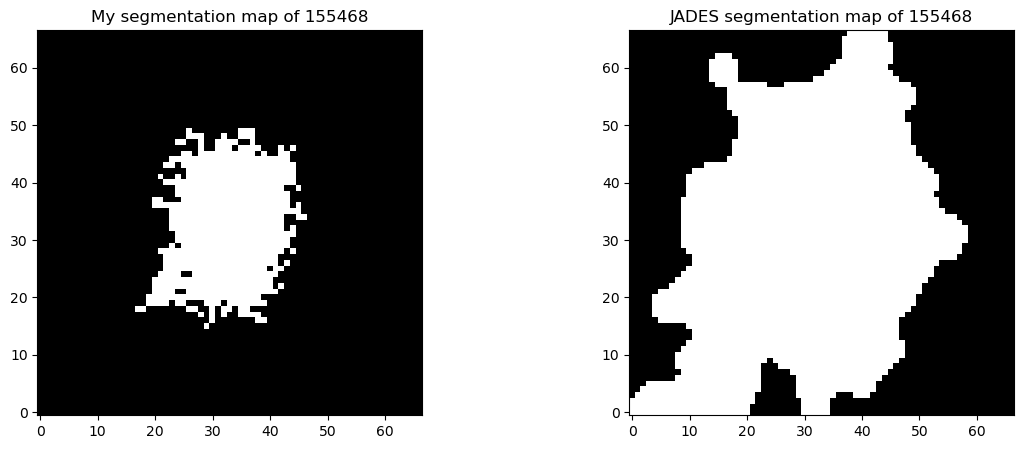

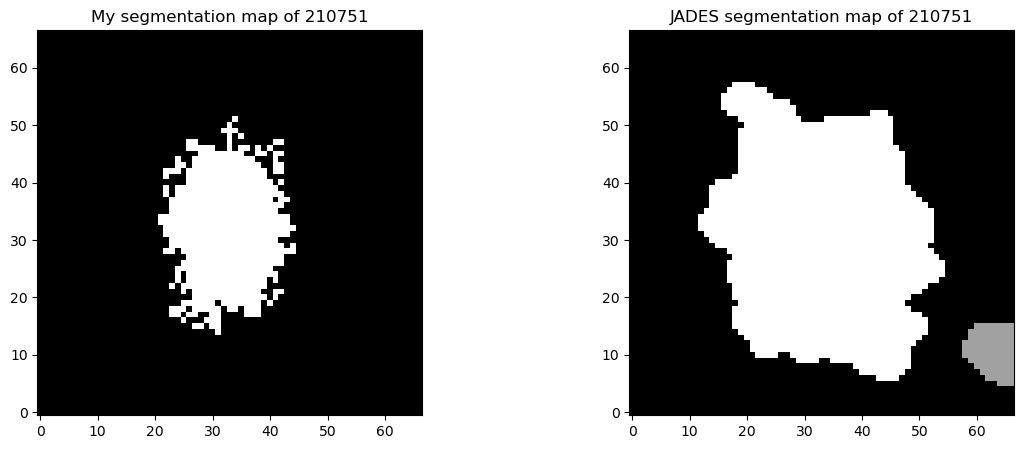

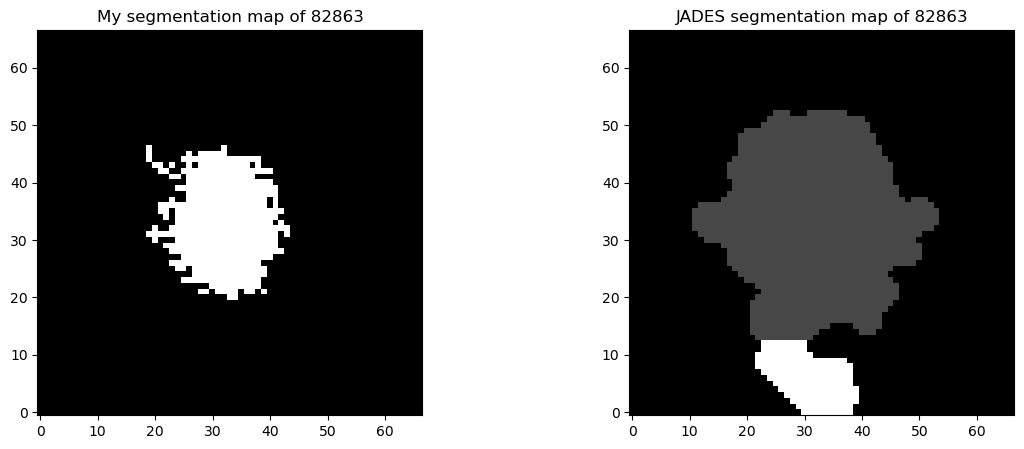

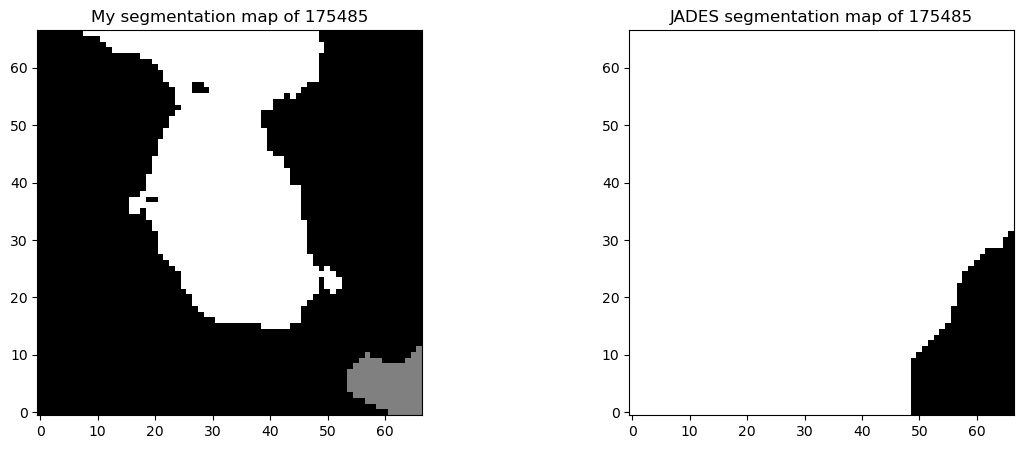

In [5]:
for gal in gal_list:
    #image:
    image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
    hdu_image_F200W=fits.open(image_F200W)
    image=hdu_image_F200W[1].data

    #error map:
    error=hdu_image_F200W[2].data

    #JADES segmentation map:
    seg_F200W=seg_dir_F200W+F"{gal}_cutout.fits"
    hdu_seg_F200W=fits.open(seg_F200W)
    seg_img=hdu_seg_F200W[1].data

    #creating a segmentation map:
    threshold = detect_threshold(image, 1.5)
    npixels = 50  # minimum number of connected pixels
    segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

    fig=plt.figure(figsize=(14, 5))
    
    #my segmentation map:
    plt.subplot(1, 2, 1)
    plt.imshow(segmap, origin='lower', cmap='gray')
    plt.title(f"My segmentation map of {gal}")

    #JADES segmentation map:
    plt.subplot(1, 2, 2)
    plt.imshow(seg_img, origin='lower', cmap='gray')
    plt.title(f"JADES segmentation map of {gal}")
    plt.show()

We will be using my own segmentation maps.

# 2. Morphology analysis

We will now run package statmorph to fit ellipses to each galaxy and derive morphological properties, as well as Sèrsic models. 

__THINGS MISSING:__
- Panel 1: check if the image is log stretch and change it if needed
- Panel 3: sigma contours?

PSF is needed to run statmorph correctly:

In [6]:
#psf:
psf_image=main_dir+"JWST_filters/JADES_ePSF_F200W.fits"
psf_hdu=fits.open(psf_image)
psf=psf_hdu[0].data

## 2.1. Galaxy 192481

In [7]:
#image:
image_F200W=cuts_dir_F200W+"192481_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [8]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+"192481_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

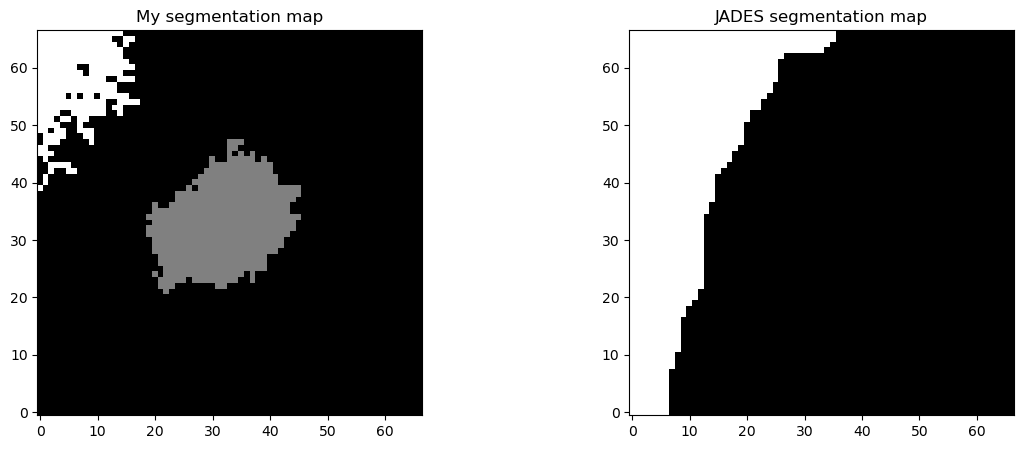

In [9]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

fig=plt.figure(figsize=(14, 5))
    
#my segmentation map:
plt.subplot(1, 2, 1)
plt.imshow(segmap, origin='lower', cmap='gray')
plt.title("My segmentation map")

#JADES segmentation map:
plt.subplot(1, 2, 2)
plt.imshow(seg_img, origin='lower', cmap='gray')
plt.title("JADES segmentation map")
plt.show()

In [10]:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)

In [11]:
morph = source_morphs[0]

In [12]:
print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 32.7458439758304
yc_centroid = 33.479183863399115
ellipticity_centroid = 0.3774989921049666
elongation_centroid = 1.6064231018379664
orientation_centroid = 0.5595415149987026
xc_asymmetry = 33.307980098856376
yc_asymmetry = 33.619876190986176
ellipticity_asymmetry = 0.37987081066708805
elongation_asymmetry = 1.6125672153502795
orientation_asymmetry = 0.5540657743706348
rpetro_circ = 11.327334776406813
rpetro_ellip = 13.643256334807663
rhalf_circ = 5.556002799685817
rhalf_ellip = 6.53427381301675
r20 = 2.919899691543882
r80 = 9.14311949597904
Gini = 0.4803975040238119
M20 = -1.1742995871188833
F(G, M20) = -0.7682427412087449
S(G, M20) = -0.014634113625950962
sn_per_pixel = 14.018851
C = 2.4786323179961354
A = 0.2446097820501559
S = 0.041047553363747276

SERSIC MODEL
sersic_amplitude = 0.28795559997638764
sersic_rhalf = 6.216782344989588
sersic_n = 0.6511351377263286
sersic_xc = 33.590160129432356
sersic_yc = 34.026837877581194
sersic_ell

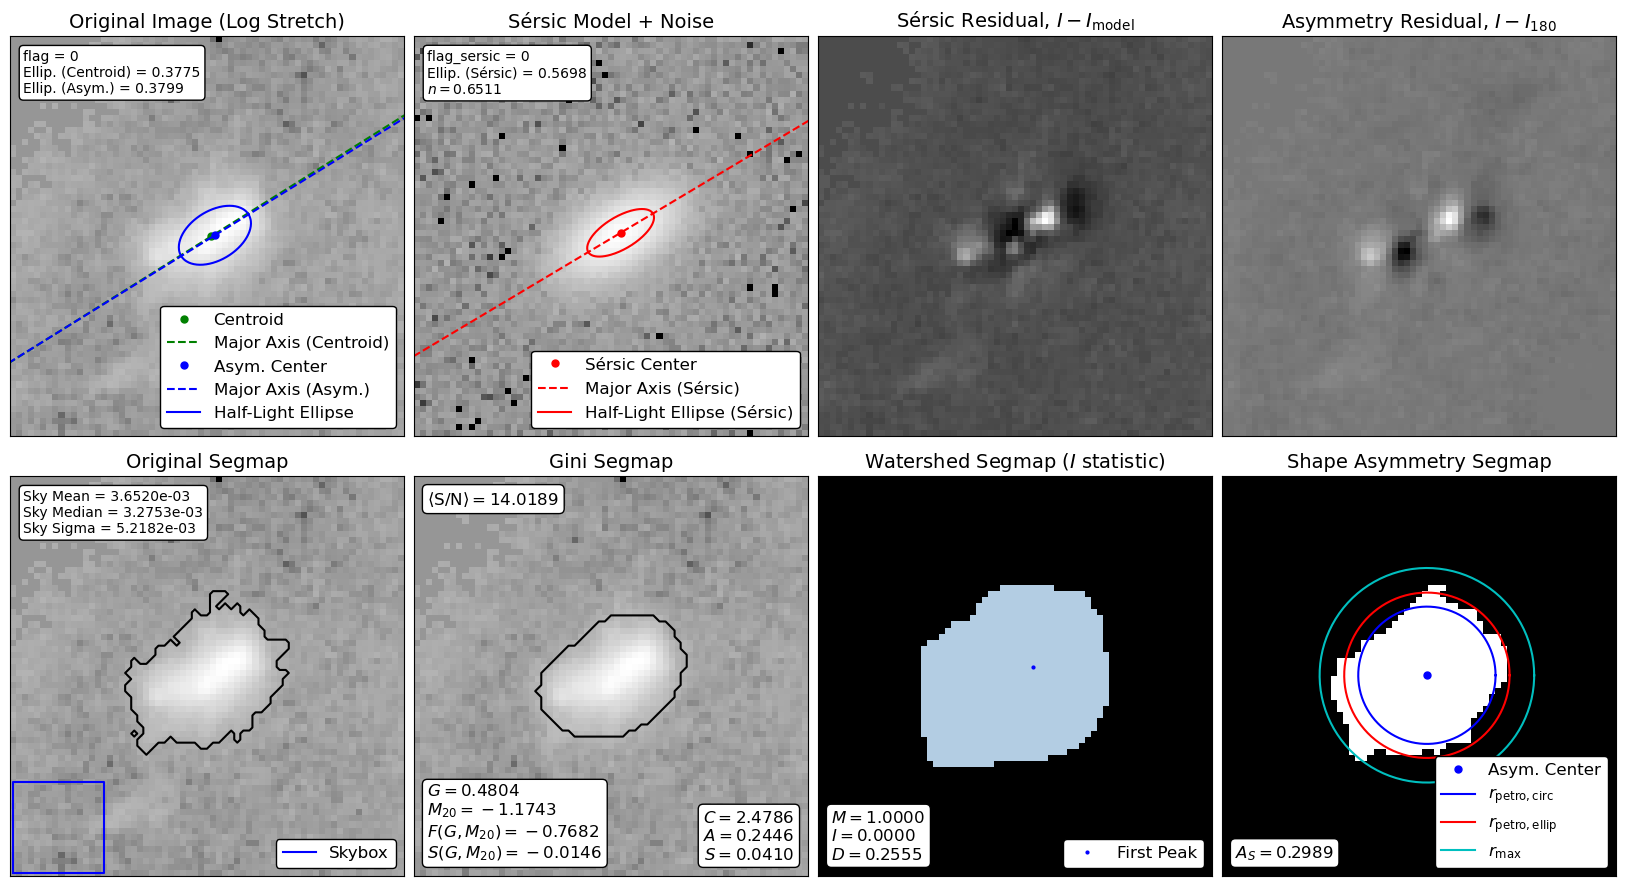

In [13]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [14]:
fig.savefig(res_dir+'192481_morphology.pdf', dpi=150)
plt.close(fig)

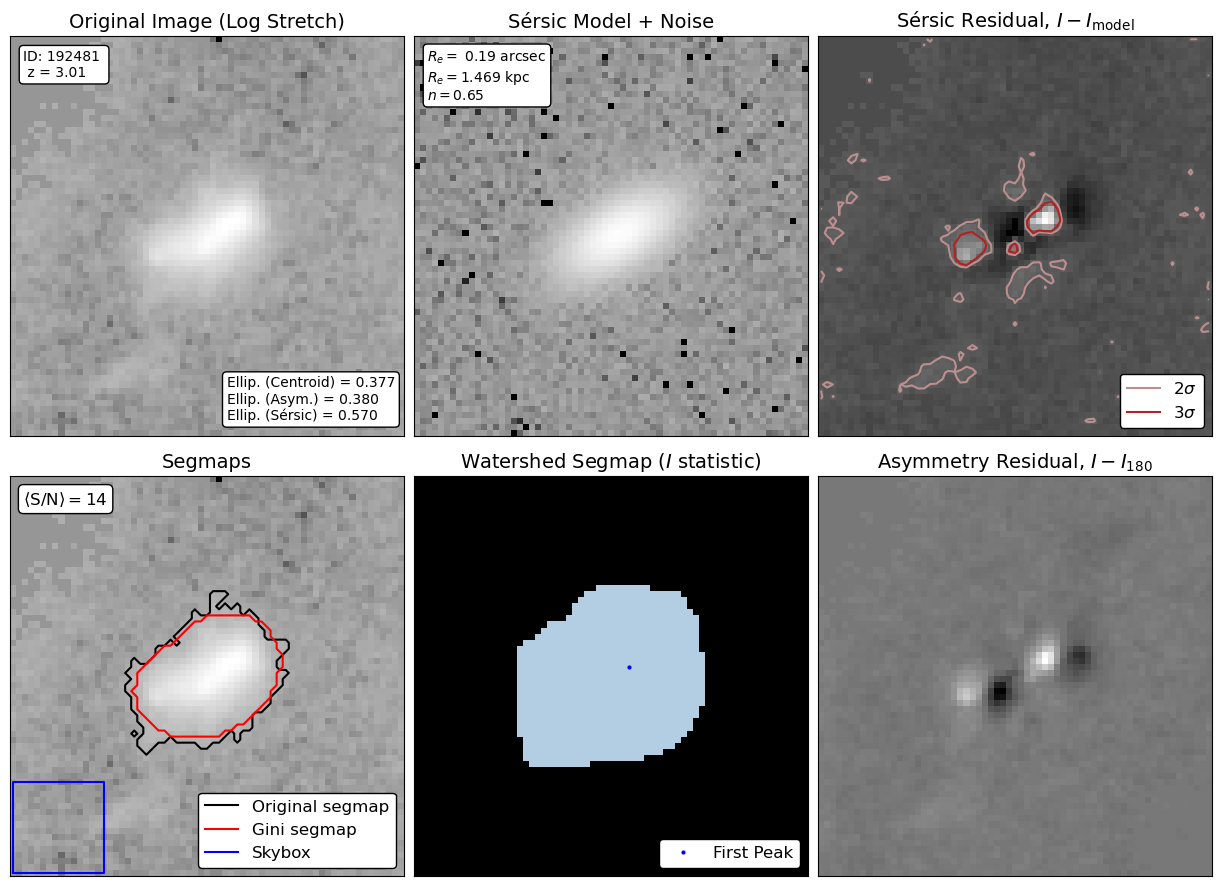

In [15]:
n=0
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [16]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.2. Galaxy 203821:

In [17]:
gal=gal_list[1]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [18]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [19]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

In [20]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 33.622191443493115
yc_centroid = 32.65896168597782
ellipticity_centroid = 0.3857790899208955
elongation_centroid = 1.6280787312682201
orientation_centroid = -0.4700055740520103
xc_asymmetry = 33.22783205734992
yc_asymmetry = 33.29432219069122
ellipticity_asymmetry = 0.38582908951593975
elongation_asymmetry = 1.62821127300192
orientation_asymmetry = -0.4745858610213549
rpetro_circ = 17.921107789341878
rpetro_ellip = 25.09591068717225
rhalf_circ = 8.800039399800896
rhalf_ellip = 10.538712796249312
r20 = 3.9970975281197743
r80 = 14.660603263574286
Gini = 0.5682158460634886
M20 = -1.317209823120023
F(G, M20) = -0.23450515456355525
S(G, M20) = 0.052441522189170475
sn_per_pixel = 13.273148
C = 2.822035481156365
A = 0.34028937573570117
S = 0.05825395555448967

SERSIC MODEL
sersic_amplitude = 0.12753666761577304
sersic_rhalf = 9.64815129113885
sersic_n = 0.9262709873669654
sersic_xc = 33.44160438321596
sersic_yc = 33.7314564724572
sersic_ellip 

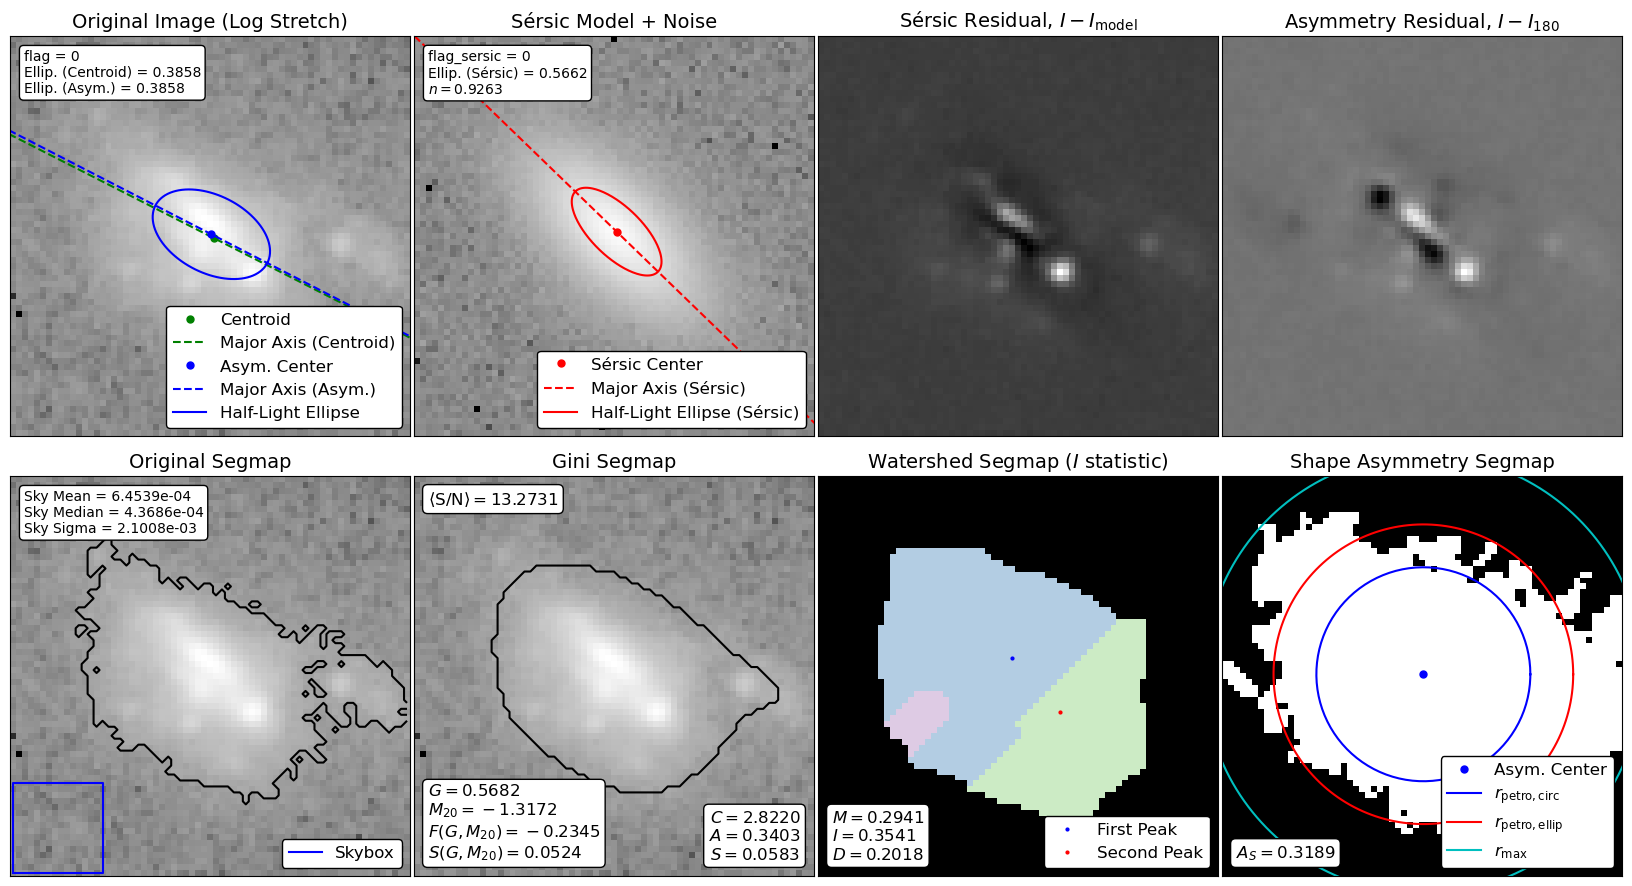

In [21]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [22]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

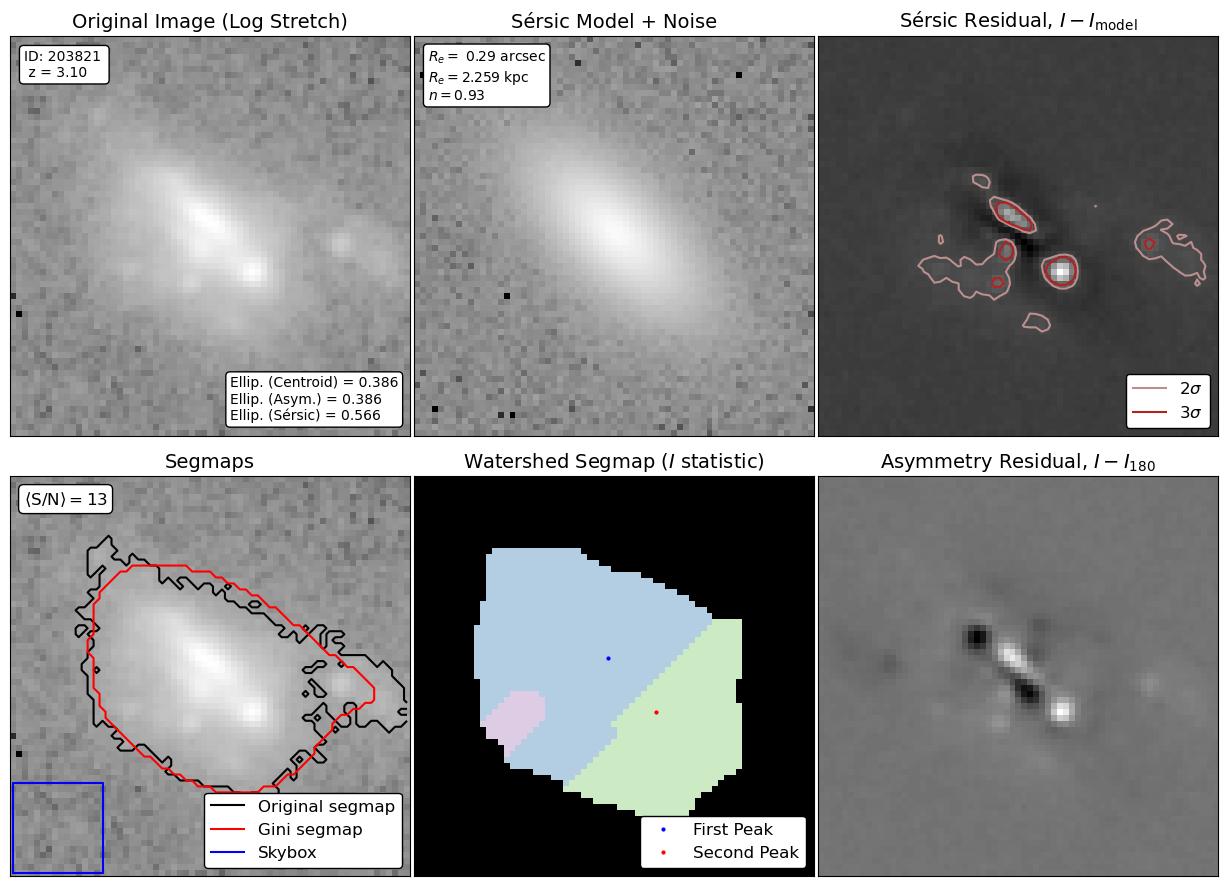

In [23]:
n=1
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [24]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.3. Galaxy 210885:

In [25]:
gal=gal_list[2]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [26]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [27]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

In [28]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 33.27240956738332
yc_centroid = 33.11767161090234
ellipticity_centroid = 0.3794493246797729
elongation_centroid = 1.6114719389902572
orientation_centroid = -1.3499678003799016
xc_asymmetry = 33.37915244618557
yc_asymmetry = 33.116025493080556
ellipticity_asymmetry = 0.37913195836171243
elongation_asymmetry = 1.6106482101434874
orientation_asymmetry = -1.3498099218247481
rpetro_circ = 7.668946895502449
rpetro_ellip = 8.836434316193413
rhalf_circ = 3.9851320254534484
rhalf_ellip = 4.808733825319132
r20 = 1.789847189022436
r80 = 6.201555753960487
Gini = 0.4940627458385082
M20 = -1.5008313032439815
F(G, M20) = -0.47431331495130546
S(G, M20) = -0.04649343277079038
sn_per_pixel = 35.953796
C = 2.698423492503542
A = 0.192641037656757
S = 0.0

SERSIC MODEL
sersic_amplitude = 0.9082976886399773
sersic_rhalf = 3.6501427282111383
sersic_n = 0.9178987058755914
sersic_xc = 33.53262430614471
sersic_yc = 33.416360992135026
sersic_ellip = 0.67918430975

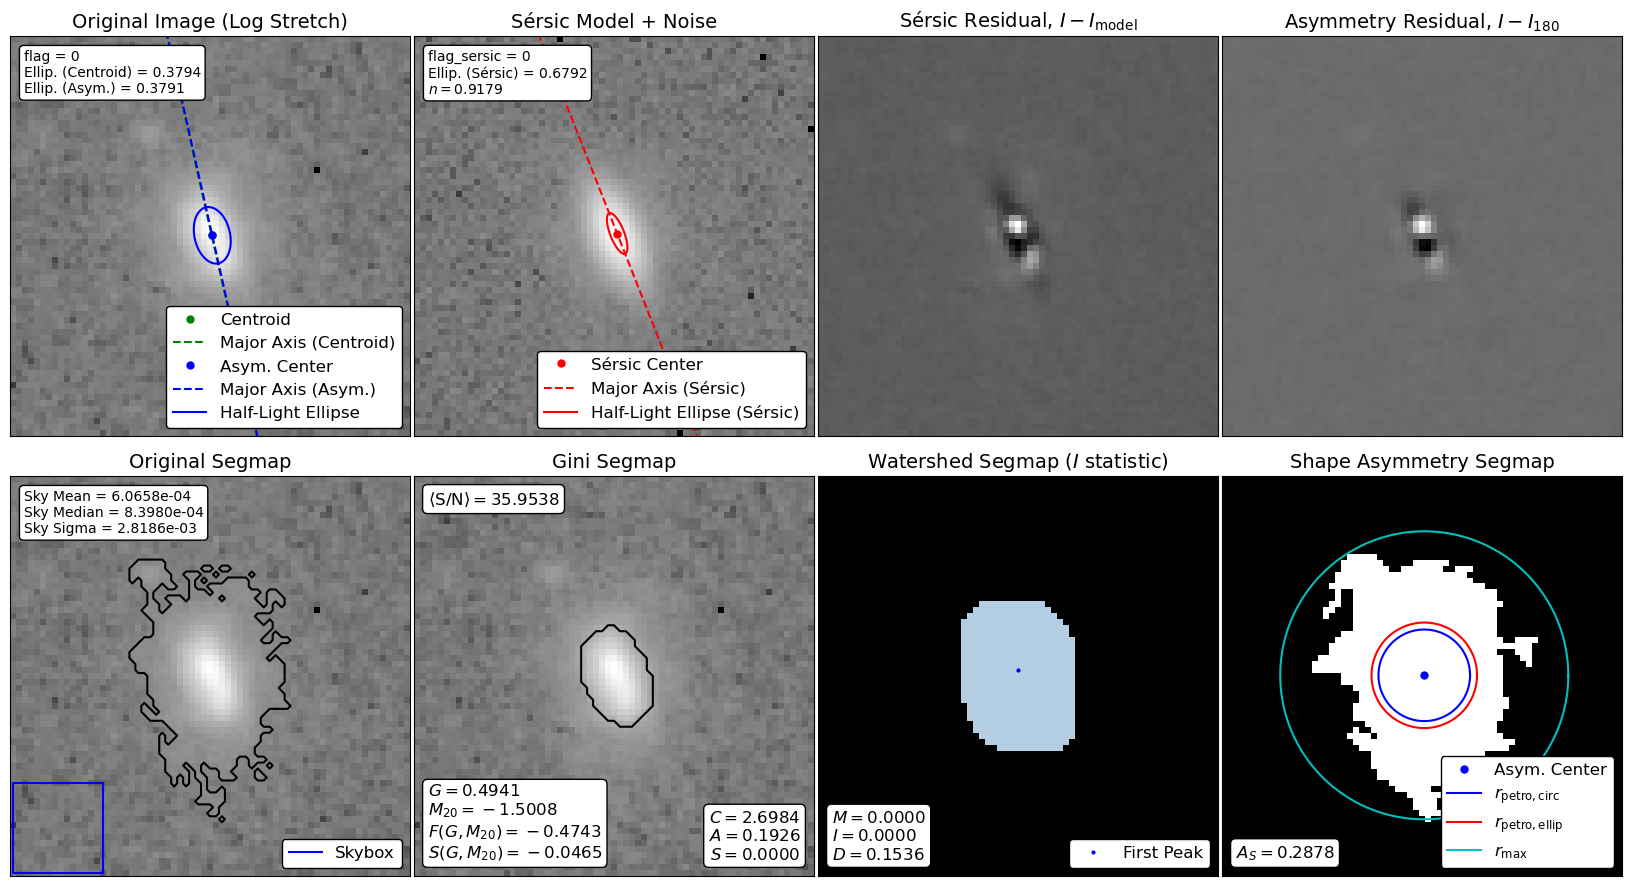

In [29]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [30]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

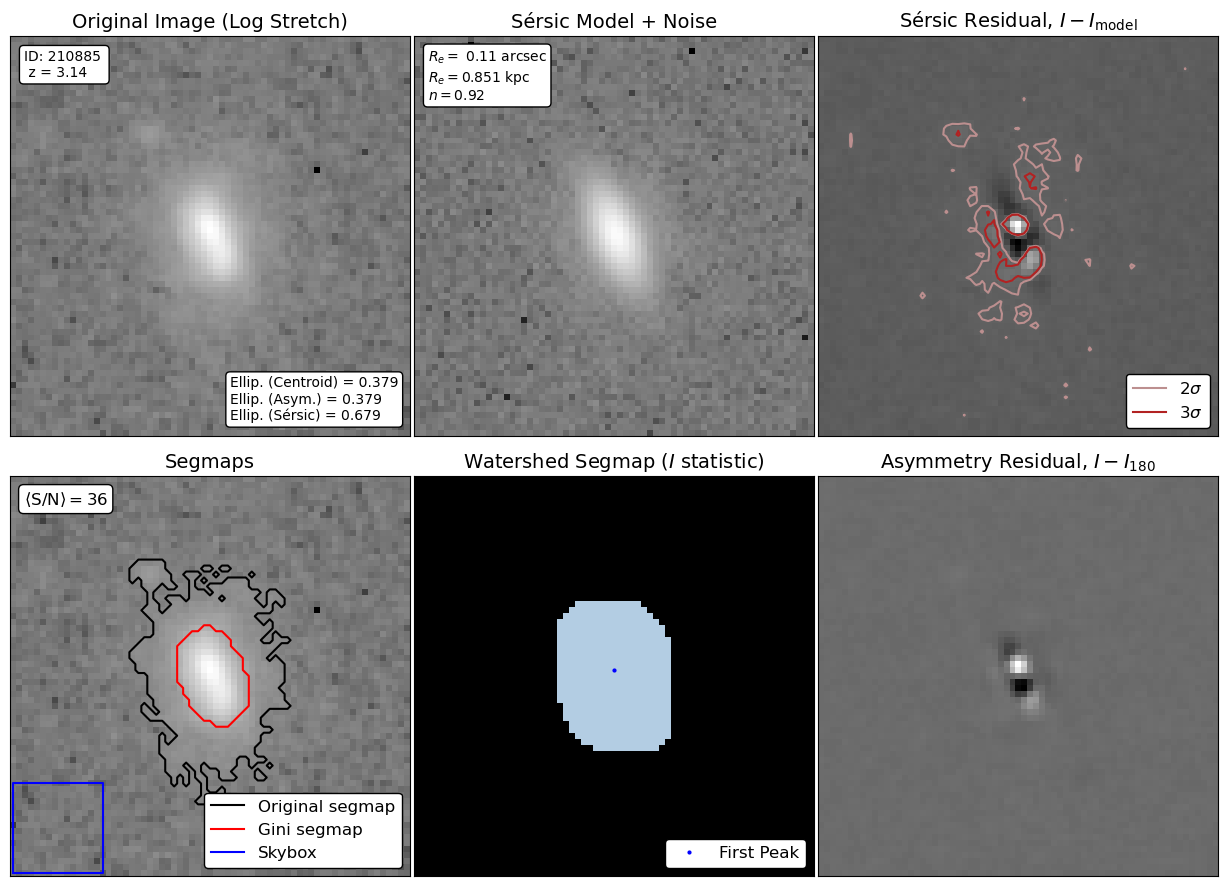

In [31]:
n=2
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [32]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.4. Galaxy 155468:

In [33]:
gal=gal_list[3]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [34]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [35]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

In [36]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 32.71153790974617
yc_centroid = 32.51156631142429
ellipticity_centroid = 0.346060096726296
elongation_centroid = 1.5291925068249794
orientation_centroid = 1.4728647506000043
xc_asymmetry = 32.83231351959719
yc_asymmetry = 32.58129068513953
ellipticity_asymmetry = 0.34580083156759445
elongation_asymmetry = 1.528586473743468
orientation_asymmetry = 1.4723204409859814
rpetro_circ = 10.310771922904184
rpetro_ellip = 11.764688600663813
rhalf_circ = 4.913348748598532
rhalf_ellip = 5.837242157303463
r20 = 2.1360759046916638
r80 = 8.476623645193529
Gini = 0.5211348042342004
M20 = -1.7828448880488397
F(G, M20) = -0.1448712116228621
S(G, M20) = -0.05889198324693029
sn_per_pixel = 16.326355
C = 2.993031100770216
A = 0.10176180772027438
S = 0.07152328689932827

SERSIC MODEL
sersic_amplitude = 0.22490099650439394
sersic_rhalf = 5.079381407665621
sersic_n = 1.3919678661208896
sersic_xc = 32.99787335656607
sersic_yc = 32.73538140602935
sersic_ellip = 

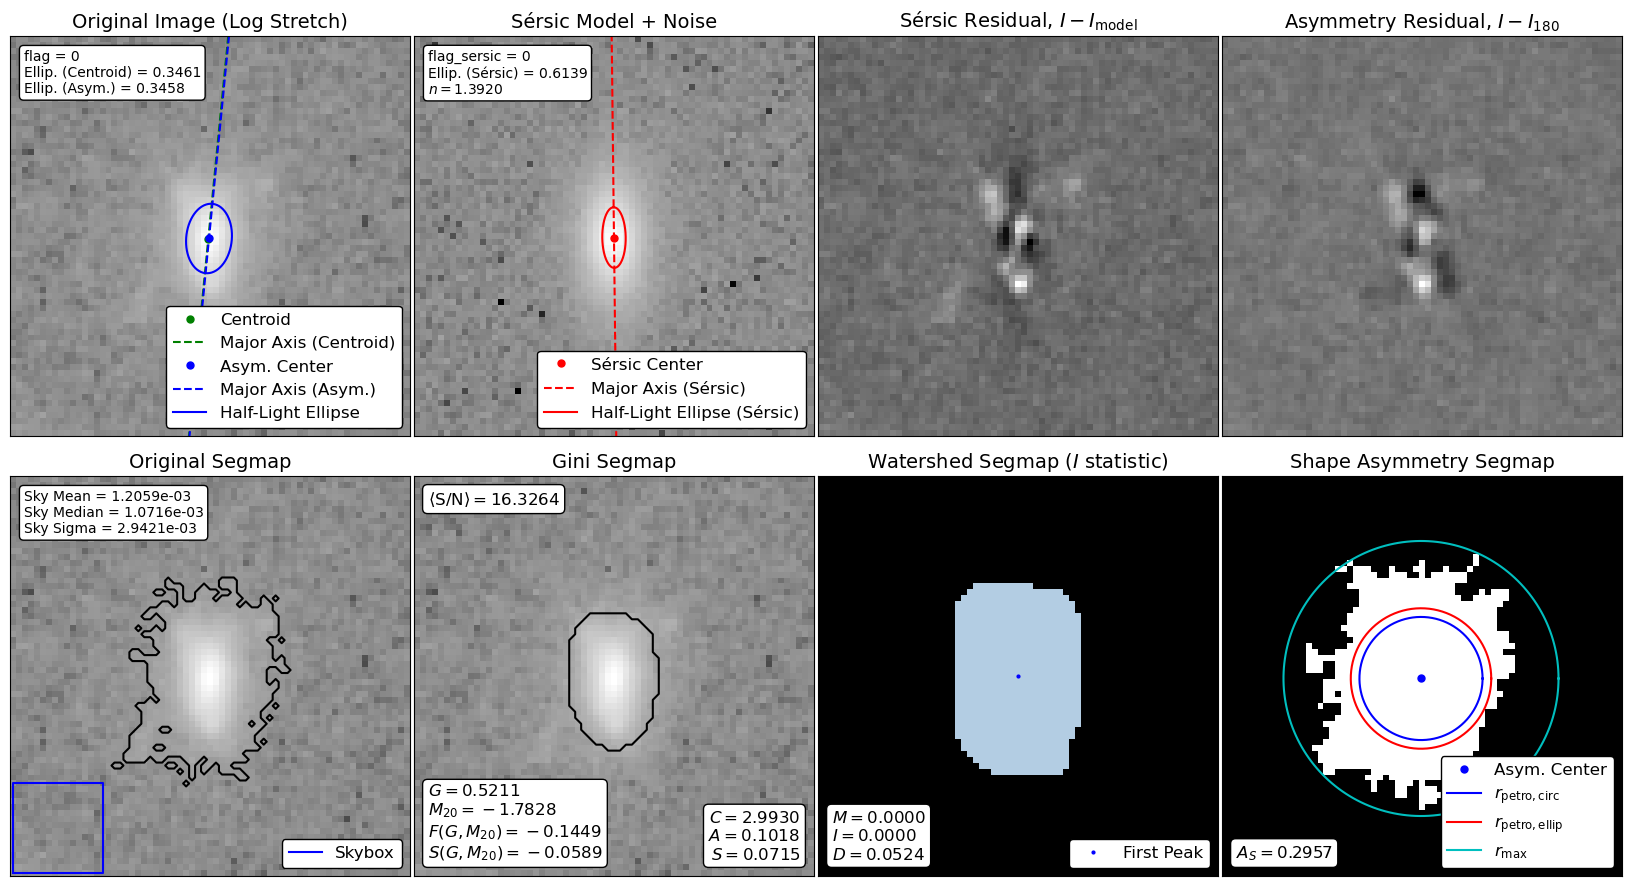

In [37]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [38]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

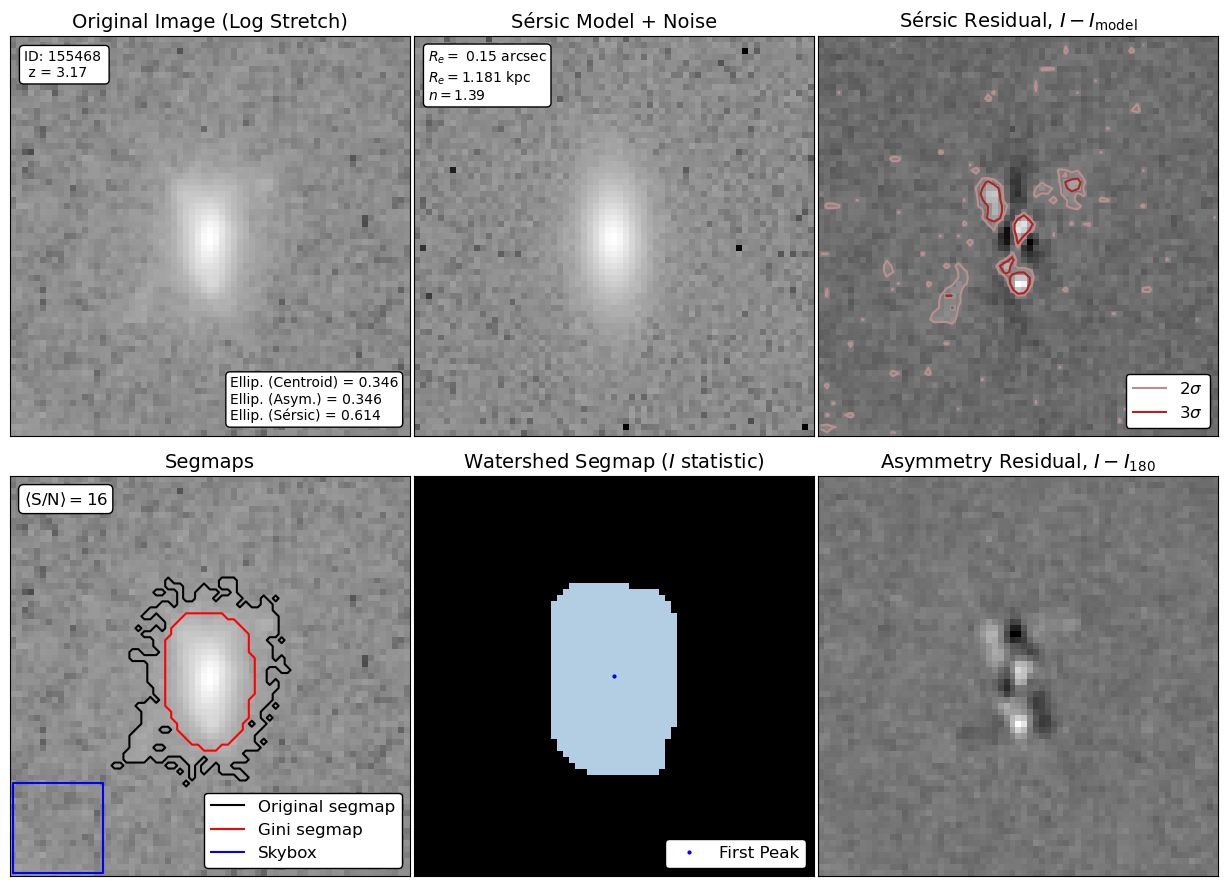

In [39]:
n=3
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [40]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.5. Galaxy 210751:

In [41]:
gal=gal_list[4]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [42]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [43]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

In [44]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 32.78845082370043
yc_centroid = 32.064626154899045
ellipticity_centroid = 0.4235843818620304
elongation_centroid = 1.7348593073004526
orientation_centroid = 1.5501674534279697
xc_asymmetry = 33.07068796039485
yc_asymmetry = 32.59003053567972
ellipticity_asymmetry = 0.42429374749938753
elongation_asymmetry = 1.7369969418543638
orientation_asymmetry = 1.5420337273299907
rpetro_circ = 9.945282951639664
rpetro_ellip = 11.013416664468982
rhalf_circ = 4.491578133326803
rhalf_ellip = 5.64869181348717
r20 = 1.9425926032418939
r80 = 7.825075047403173
Gini = 0.4862703219369138
M20 = -1.8195144849110128
F(G, M20) = -0.2920383683689449
S(G, M20) = -0.09850489468508616
sn_per_pixel = 26.043709
C = 3.025533903224783
A = 0.20461100545213737
S = 0.07971456648653373

SERSIC MODEL
sersic_amplitude = 0.2434516075291418
sersic_rhalf = 4.825357076378861
sersic_n = 1.5409086974506845
sersic_xc = 33.19243342759589
sersic_yc = 32.76074491614492
sersic_ellip = 

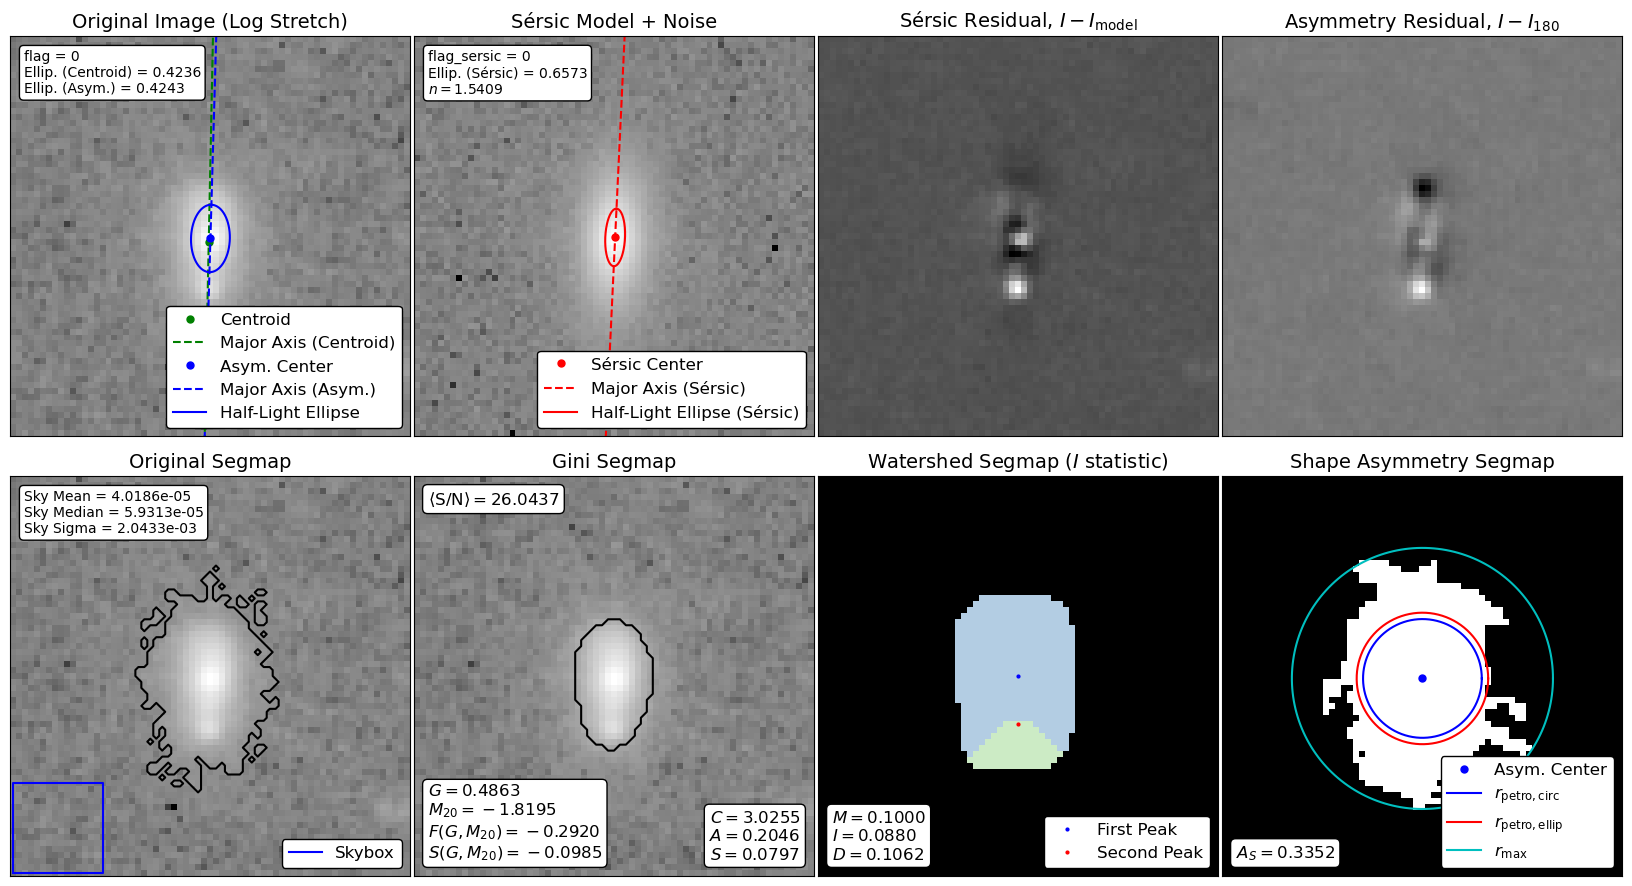

In [45]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [46]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

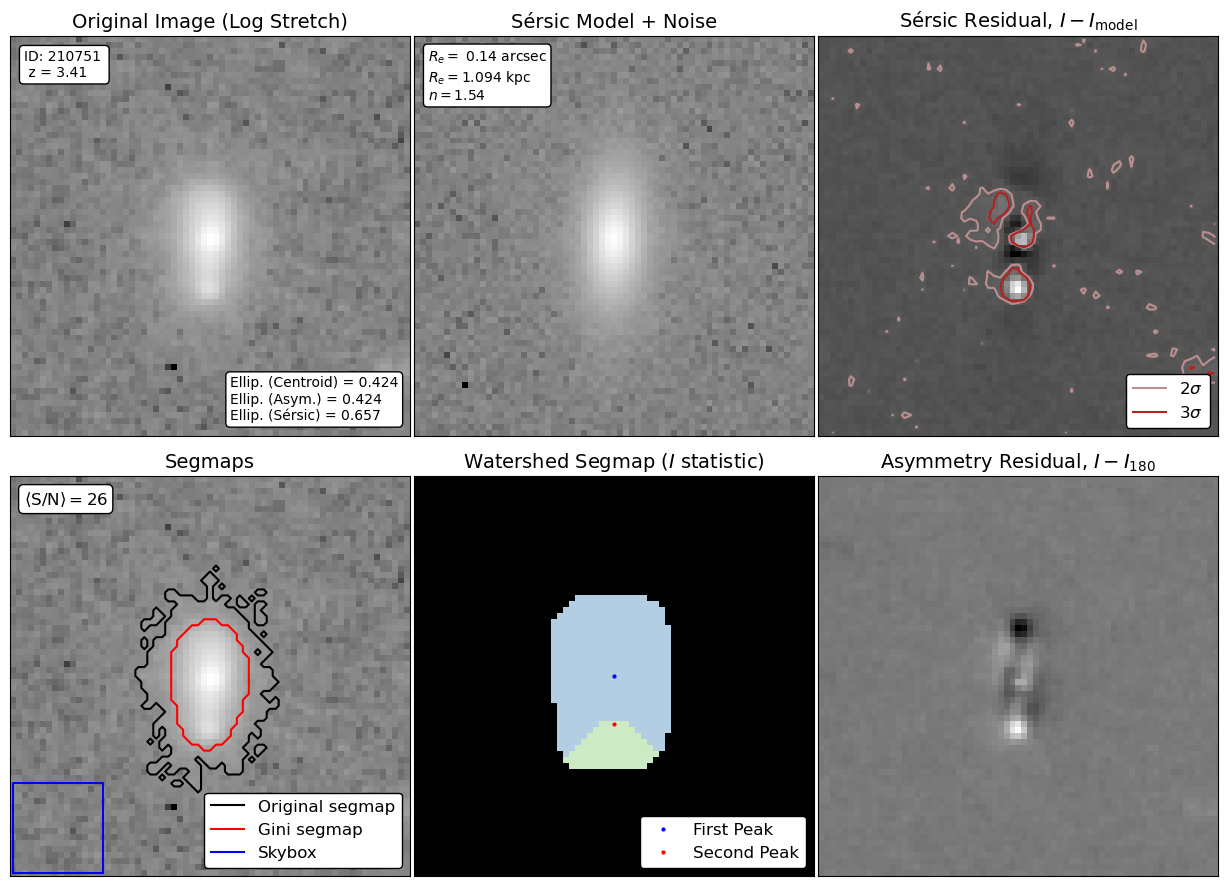

In [47]:
n=4
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [48]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.6. Galaxy 82863:

In [49]:
gal=gal_list[5]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [50]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [51]:
#creating a segmentation map:
threshold = detect_threshold(image, 1.5)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

In [52]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 32.41377835382
yc_centroid = 33.11155662374301
ellipticity_centroid = 0.33736869022839555
elongation_centroid = 1.5091348465629848
orientation_centroid = -1.5203524264082406
xc_asymmetry = 32.72804944920149
yc_asymmetry = 32.64492771597088
ellipticity_asymmetry = 0.33811288087935965
elongation_asymmetry = 1.5108316374679784
orientation_asymmetry = -1.508150844377853
rpetro_circ = 9.076441969206375
rpetro_ellip = 9.84371916405699
rhalf_circ = 4.249749337577956
rhalf_ellip = 4.965232295316335
r20 = 2.203323940510797
r80 = 7.135872418843666
Gini = 0.49191983122680355
M20 = -1.1884344952913204
F(G, M20) = -0.7014117301904372
S(G, M20) = -0.005191761930958105
sn_per_pixel = 14.156385
C = 2.5518436169580134
A = 0.21555663238916925
S = 0.09144577642746399

SERSIC MODEL
sersic_amplitude = 0.4935547444952624
sersic_rhalf = 4.580969540280744
sersic_n = 0.45723032920351736
sersic_xc = 32.900803728261465
sersic_yc = 33.09266574478543
sersic_ellip =

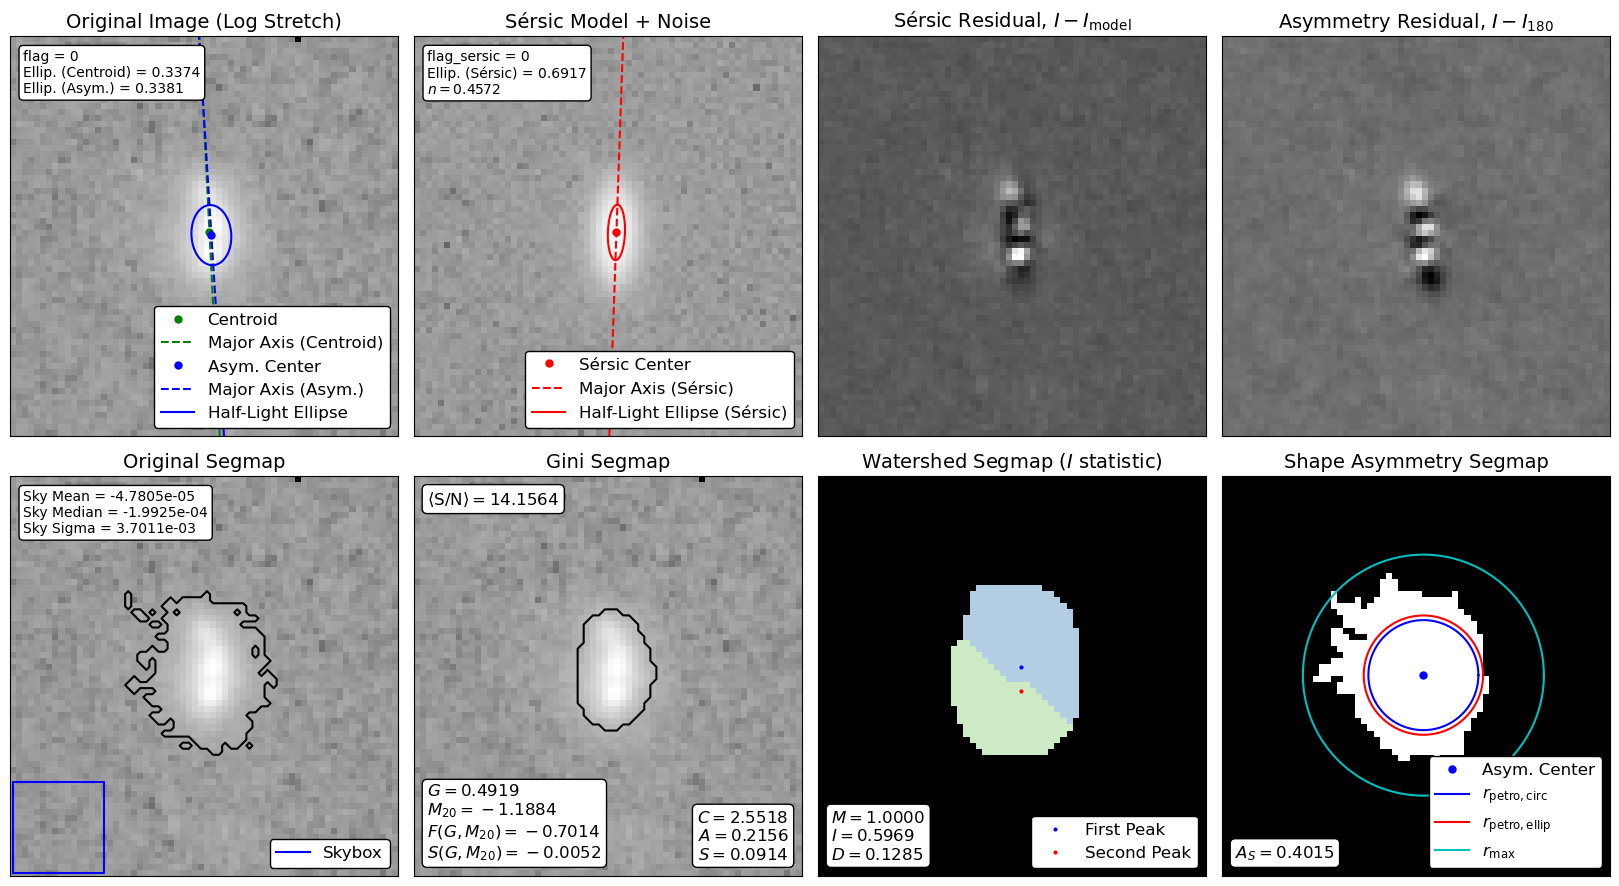

In [53]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [54]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

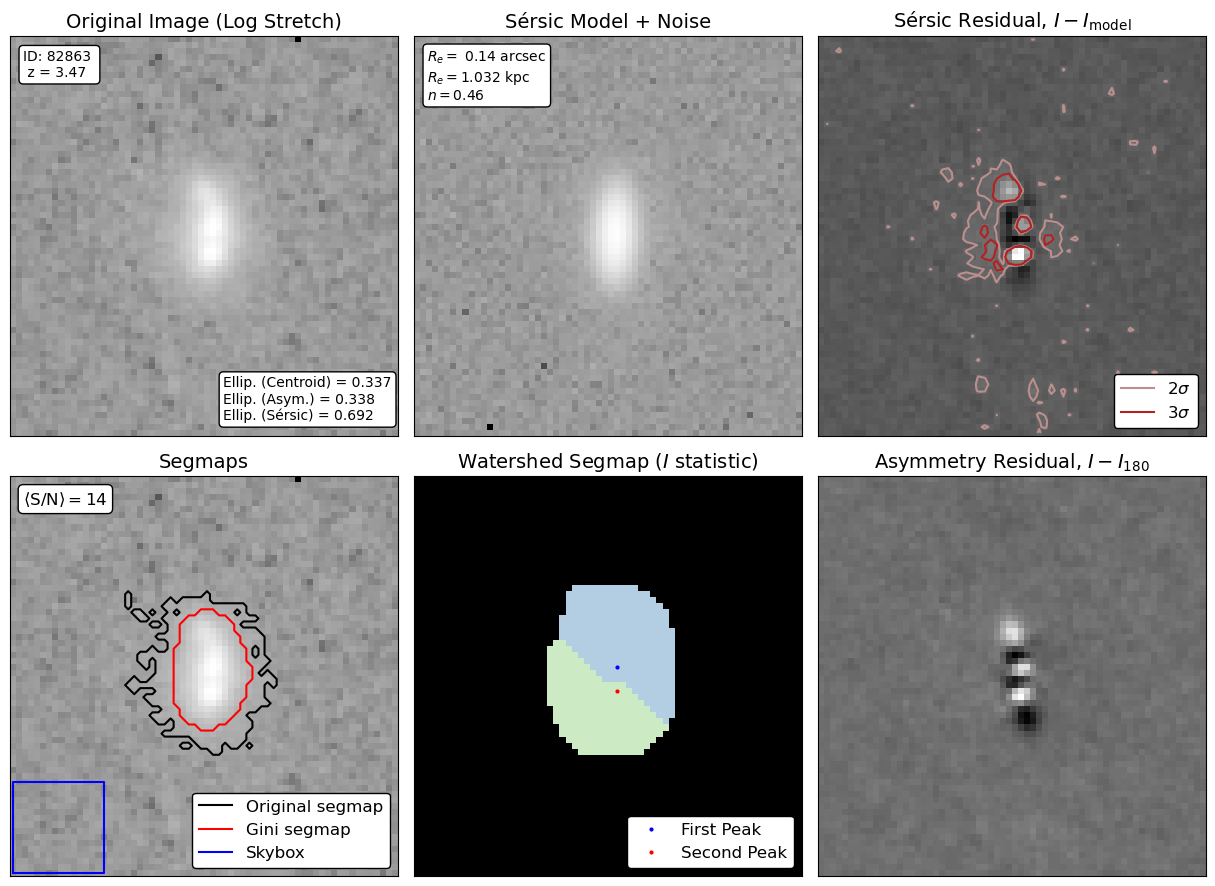

In [55]:
n=5
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [56]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

## 2.7. Galaxy 175485:

This galaxy's segmentation map is giving problems (bc of emission in the upper part). We create a mask for those pixels. Masking didn't work so we increase threshold from 1.5 sigma to 3 sigma

In [57]:
gal=gal_list[6]

#image:
image_F200W=cuts_dir_F200W+f"{gal}_cutout.fits"
hdu_image_F200W=fits.open(image_F200W)
image=hdu_image_F200W[1].data

#error map:
error=hdu_image_F200W[2].data

In [58]:
#JADES segmentation map:
seg_F200W=seg_dir_F200W+f"{gal}_cutout.fits"
hdu_seg_F200W=fits.open(seg_F200W)
seg_img=hdu_seg_F200W[1].data

In [59]:
#creating a segmentation map:
threshold = detect_threshold(image, 4)
npixels = 50  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels) #photutils (usar los de Jades y comparar las dos)

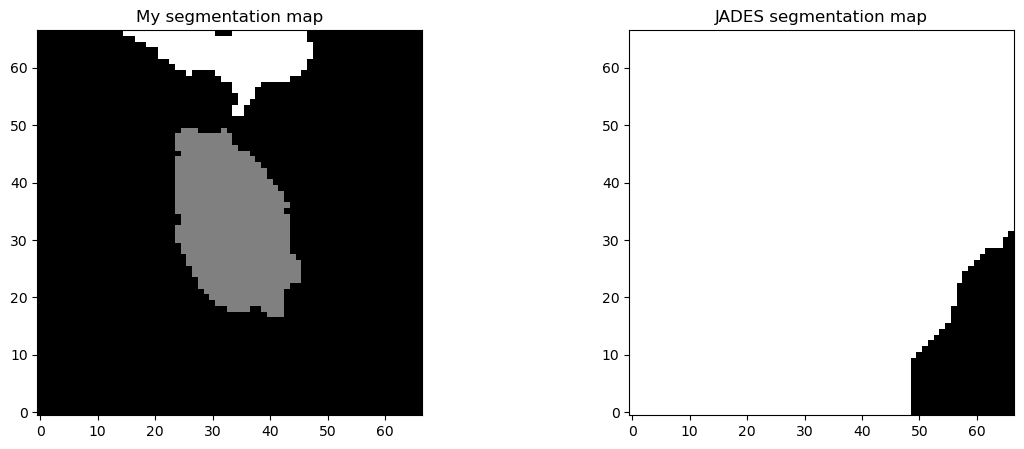

In [60]:
fig=plt.figure(figsize=(14, 5))
    
#my segmentation map:
plt.subplot(1, 2, 1)
plt.imshow(segmap, origin='lower', cmap='gray')
plt.title("My segmentation map")

#JADES segmentation map:
plt.subplot(1, 2, 2)
plt.imshow(seg_img, origin='lower', cmap='gray')
plt.title("JADES segmentation map")
plt.show()

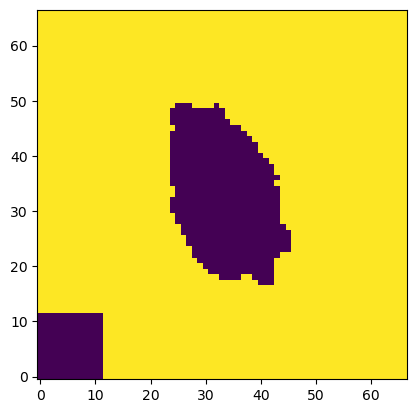

In [61]:
#mask:
row, col = np.shape(image)

mask=np.ones((row,col),dtype=bool)
mask[segmap.data==1]=False
mask[0:12,0:12]=False
plt.imshow(mask, origin='lower')

In [62]:
#morphological analysis:
source_morphs = statmorph.source_morphology(image, segmap, weightmap=error, mask=mask, skybox_size=12, psf=psf)
morph = source_morphs[0]

print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print()
print('SERSIC MODEL')
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sersic_chi2_dof =', morph.sersic_chi2_dof)
print()
print('OTHER')
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

BASIC MEASUREMENTS (NON-PARAMETRIC)
xc_centroid = 33.37332789667641
yc_centroid = 32.43222061308716
ellipticity_centroid = 0.4626634724303753
elongation_centroid = 1.8610311205214434
orientation_centroid = -1.3005290111886634
xc_asymmetry = 33.24504774901325
yc_asymmetry = 32.572193226588766
ellipticity_asymmetry = 0.46268504121796405
elongation_asymmetry = 1.8611058256534678
orientation_asymmetry = -1.2999572469842668
rpetro_circ = 11.069656161696246
rpetro_ellip = 15.79343687146828
rhalf_circ = 5.00659962158828
rhalf_ellip = 6.417156398069982
r20 = 2.1442642478151446
r80 = 8.834608904074644
Gini = 0.5301648493136701
M20 = -1.9724861429515306
F(G, M20) = 0.031248901168078103
S(G, M20) = -0.07631237304972938
sn_per_pixel = 75.61504
C = 3.0745451208599843
A = 0.21759958476040045
S = 0.09123025450891076

SERSIC MODEL
sersic_amplitude = 0.34207622738186083
sersic_rhalf = 9.29685073050787
sersic_n = 3.964182194672408
sersic_xc = 33.36900379520856
sersic_yc = 32.81184010102346
sersic_ellip 

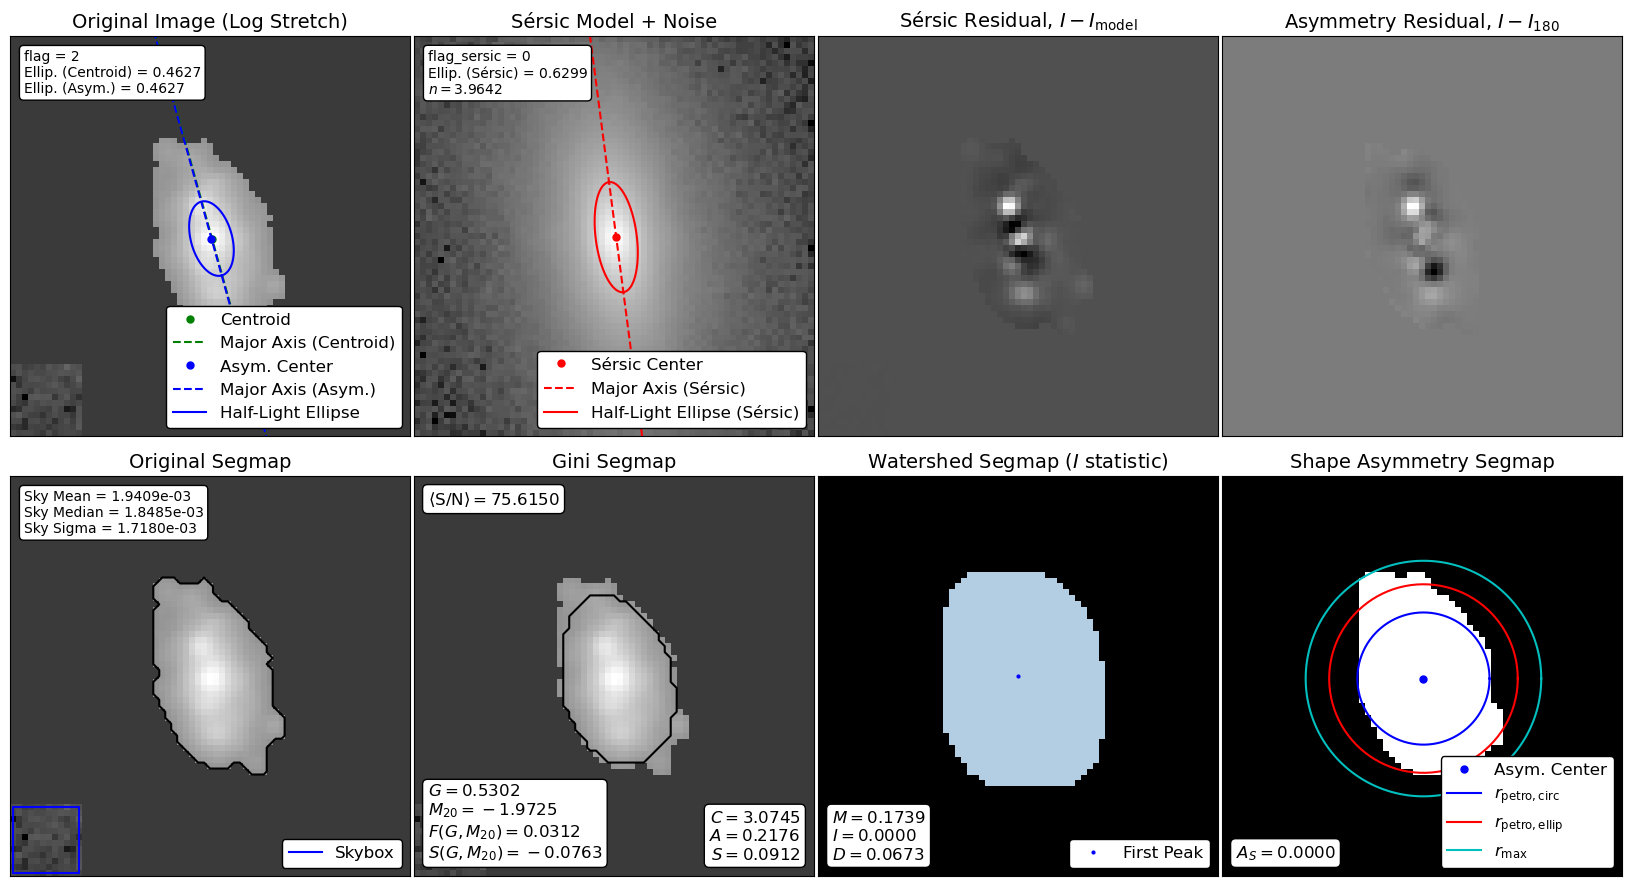

In [63]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [64]:
fig.savefig(res_dir+f'{gal}_morphology.pdf', dpi=150)
plt.close(fig)

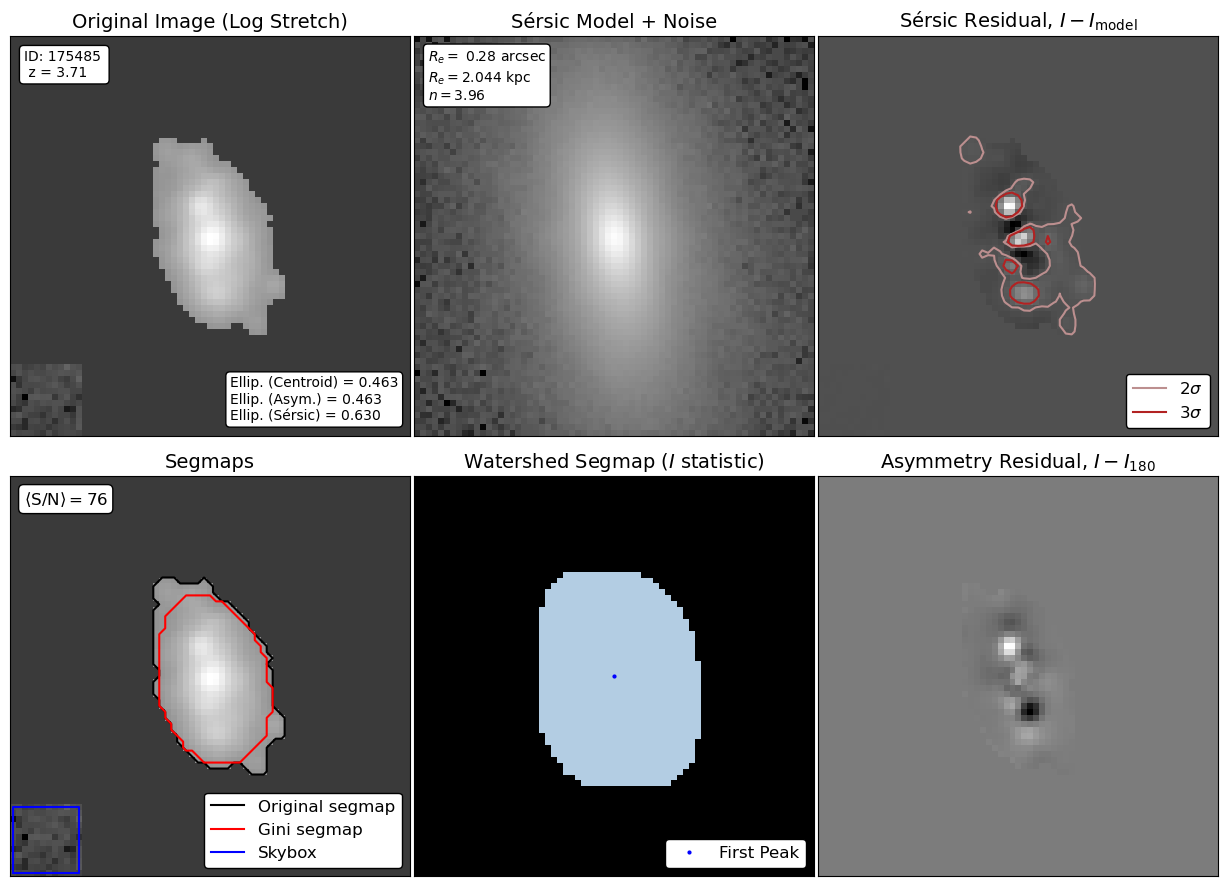

In [65]:
n=6
z=gal_z[n]
id=gal_list[n]
fig2 = make_figure_leo(morph,z,id)

In [66]:
fig2.savefig(res_dir+f'{id}_morphology_mod.pdf', dpi=150)
plt.close(fig2)

# Timer:

In [67]:
time_end = datetime.now()
print(f"Initial time...: {time_ini}")
print(f"Final time.....: {time_end}")
print(f"Excecution time: {time_end-time_ini}")

Initial time...: 2024-03-21 08:18:01.478363
Final time.....: 2024-03-21 08:18:46.162048
Excecution time: 0:00:44.683685
